# Статистический анализ данных

## Описание проекта:

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Тарифы

### Тариф "Смарт"

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг свех тарифного пакета:
    1. минута разговора: 3 рубля;
    2. сообщение: 3 рубля;
    3. 1 Гб интернет-трафика: 200 рублей;

### Тариф "Ультра"

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг свех тарифного пакета:
    1. минута разговора: 1 рубль;
    2. сообщение: 1 рубль;
    3. 1 Гб интернет-трафика: 150 рублей;

### Примечание:

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Данные

Данные разделены на несколько файлов:
1. Звонки, путь к файлу: `/datasets/calls.csv`;
2. Интернет-трафик, путь к файлу: `/datasets/internet.csv`;
3. Сообщения, путь к файлу: `/datasets/messages.csv`;
4. Тарифы, путь к файлу: `/datasets/tariffs.csv`;
5. Пользователи, путь к файлу: `/datasets/users.csv`;

### Подготовка и настройка окружения

Импортируем необходимые для исследования библиотеки и выставим настройки для удобства отображения в Jupiter Notebook:

#### Импорт:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st 
import matplotlib.pyplot as plt

#### Выставление настроек:

In [2]:
%matplotlib inline
pd.set_option('display.float_format', '{:,.2f}'.format)

### Подготовка и объединение данных в один датасет

На этом шаге мы:
1. изучим данные, предварительно открыв каждый;
2. выполним предобработку, чтобы объединить в итоговый датасет уже подготовленные к анализу данные;
3. объединим в один датасе с названием `data`.

#### 1. Загрузка и изучение данных

##### Звонки

По документации таблица `calls` содержит информацию о звонках:
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

Откроем информацию о звонках, используя метод `read_csv('путь_к_файлу.csv')` из библиотеки `pandas`, которую мы импортировали ранее.

In [3]:
calls = pd.read_csv('/datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Посмотрим общую информацию о данных. Воспользуемся методом `info()`, применив его к датасету `calls`:

In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Информация о данных в `calls`:

- Размеры таблицы:
1. строки - 202607;
2. столбцы - 4.

- Типы данных:
1. Вещественный `float64` - 1,
2. Целочисленный `int64` - 1,
3. Строковый `object` - 2.

**Вывод**:
1. Длительность звонков `duration` представлена вещественным типом данных. Согласну пункту `Примечание` в описании тарифов, необходимо округлить секунды до минут и привести к целочисленному типу;
2. Столбец с датой звонка `call_date` представлен строковым типом данных. Необходимо привести к типу `datetime64[ns]`.

Аналогично поступим с остальными данными.

##### Интернет-трафик

Таблица `internet` (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

In [5]:
internet = pd.read_csv('/datasets/internet.csv')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Информация о данных в `internet`:

- Размеры таблицы:
1. строки - 149396;
2. столбцы - 5.

- Типы данных:
1. Вещественный `float64` - 1,
2. Целочисленный `int64` - 2,
3. Строковый `object` - 2.

**Вывод**:
1. Объём интернет-трафика `mb_used` представлен вещественным типом данных в мегабайтах. Согласну пункту `Примечание` в описании тарифов, необходимо перевести в гигабайты из расчета `1Гб = 1024мб`, округлить до целого в большую сторону и привести к целочисленному типу;
2. Столбец с датой интернет-сессии `session_date` представлен строковым типом данных. Необходимо привести к типу `datetime64[ns]`.
3. Присутствует столбец `Unnamed: 0`, который совпадает с индексацией строк. В столбце нет необходимости. Можно удалить.

##### Сообщения

Таблица `messages` (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

In [7]:
messages = pd.read_csv('/datasets/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Информация о данных в `messages`:

- Размеры таблицы:
1. строки - 123036;
2. столбцы - 3.

- Типы данных:
1. Целочисленный `int64` - 1,
2. Строковый `object` - 2.

**Вывод**:

Столбец с датой сообщения `message_date` представлен строковым типом данных. Необходимо привести к типу `datetime64[ns]`.

##### Тарифы

Таблица `tariffs` (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [9]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Информация о данных в `tariffs`:

- Размеры таблицы:
1. строки - 2;
2. столбцы - 8.

- Типы данных:
1. Целочисленный `int64` - 7,
2. Строковый `object` - 1.

**Вывод**:
Вся информация о тарифах представлены в нужных форматах. Предобработка не требуется.

##### Данные пользователей

Таблица `users` (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

In [11]:
users = pd.read_csv('/datasets/users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Информация о данных в `users`:

- Размеры таблицы:
1. строки - 500;
2. столбцы - 8.

- Типы данных:
1. Целочисленный `int64` - 2,
2. Строковый `object` - 6.

**Вывод**:
1. В столбце `churn_date` имеются пропуски. Это значит, что на момент выгрузки данных пользователи, у которых наблюдается пропуск в этом столбце, пользуются тарифом. В идеале установить вместо пропусков дату выгрузки данных. Так как в рамках проекта эта информация недоступна, то оставим как есть;
2. Столбцы с датами подключения тарифа `reg_date` и прекращения пользования тарифом `churn_date` представлены строковым типом данных. Необходимо привести к типу `datetime64[ns]`.

#### 2. Предобработка данных

В этом пункте мы выполним предобработку, опираясь на выводы, сделанные ранее при загрузке и изучении данных:
- приведем данные к нужному типу
- проверим длительность звонков, интернет сессий и количества смс в день на предмет аномальных значений
- для каждого пользователя посчитаем месячное использование услуг
- для каждого пользователя посчитаем помесячную выручку

##### Типы данных

Переведем все даты из строкового представления в `datetime64[ns]`.

In [13]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])

Проверим изменения с помощью атрибута `dtypes`, применив его к нужному датасету.

In [14]:
calls.dtypes

id                   object
call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object

In [15]:
messages.dtypes

id                      object
message_date    datetime64[ns]
user_id                  int64
dtype: object

In [16]:
internet.dtypes

Unnamed: 0               int64
id                      object
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object

In [17]:
users.dtypes

user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object

##### Проверка строковых данных

В этом подпункте мы проверим, правильно ли выгрузилась информация, представленная в виде текста. Это могут быть пустые строки из пробелов, лишние пробелы до и/или после нужного значения и подобные неккоректности и опечатки.

In [18]:
# звонки
len(calls['id'].unique())

202607

In [19]:
# сообщения
len(messages['id'].unique())

123036

In [20]:
# интернет
len(internet['id'].unique())

149396

In [21]:
# данные пользователей
users['city'].sort_values().unique()

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

In [22]:
# данные пользователей
users['first_name'].sort_values().unique()

array(['Авксентий', 'Агата', 'Агафья', 'Агнесса', 'Адам', 'Аким', 'Аксён',
       'Алан', 'Алевтина', 'Александр', 'Александра', 'Алексей', 'Алина',
       'Алиса', 'Алла', 'Альберта', 'Альбин', 'Альфред', 'Алёна',
       'Анатолий', 'Анвар', 'Ангелина', 'Андрей', 'Анжелика', 'Анита',
       'Антонина', 'Анфиса', 'Арина', 'Арнольд', 'Арсен', 'Арсений',
       'Артемий', 'Артём', 'Аурелия', 'Афанасий', 'Ахмет', 'Аюна',
       'Белла', 'Берта', 'Борис', 'Вадим', 'Валентина', 'Валерий',
       'Валерия', 'Варвара', 'Варлам', 'Василиса', 'Вениамин', 'Вера',
       'Вероника', 'Веселина', 'Виктор', 'Виктория', 'Виолетта',
       'Виталий', 'Владимир', 'Владислав', 'Владислава', 'Всеволод',
       'Габриель', 'Габриэль', 'Гайдар', 'Галина', 'Гарри', 'Гектор',
       'Гелена', 'Геннадий', 'Геодар', 'Георгий', 'Георгина', 'Геральд',
       'Герасим', 'Глеб', 'Гордей', 'Григорий', 'Дайна', 'Дана', 'Даниил',
       'Даниэла', 'Дебора', 'Демьян', 'Денис', 'Джемма', 'Джозефина',
       'Джулия', '

In [23]:
# данные пользователей
users['last_name'].sort_values().unique()

array(['Ёлчина', 'Ёркин', 'Ёркина', 'Ёрохов', 'Ёрохова', 'Абаимов',
       'Абакумов', 'Абакшина', 'Абалакова', 'Абалдуева', 'Абалкин',
       'Абашкин', 'Абашкина', 'Абдулина', 'Абоимов', 'Абрамович',
       'Абрамцев', 'Абрамычева', 'Абрашина', 'Абрикосова', 'Авдеев',
       'Авдеенко', 'Авдонюшкин', 'Авдушева', 'Авдышев', 'Авдюков',
       'Авраамова', 'Авраменко', 'Авринский', 'Аврорин', 'Авроров',
       'Авросимова', 'Авросинова', 'Авсейкина', 'Авчинникова', 'Агаев',
       'Агаева', 'Агапеева', 'Агеева', 'Адаменко', 'Адамов', 'Азаров',
       'Азерников', 'Азимова', 'Акимов', 'Акимчин', 'Акимычева',
       'Акиндинов', 'Акинин', 'Акинфьев', 'Аксёнов', 'Акуленко',
       'Александрова', 'Александрович', 'Александрюк', 'Алексеева',
       'Алексеенко', 'Алексеичев', 'Аленникова', 'Алесин', 'Алехина',
       'Алешин', 'Алешина', 'Алешкова', 'Алиев', 'Алфеева', 'Алфимов',
       'Алфимова', 'Алымова', 'Алютин', 'Алюшина', 'Алёшко', 'Алёшкова',
       'Амелин', 'Амелишко', 'Амельченк

##### Проверка дат

Для дат построим гистограммы. Они покажут длину временного отрезка, и как по этому отрезку распределены данные.

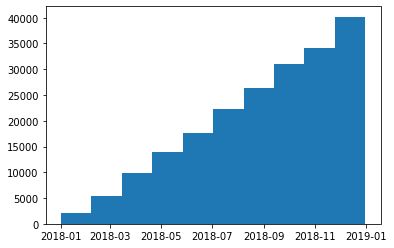

In [25]:
# звонки
plt.hist(data=calls, x='call_date');

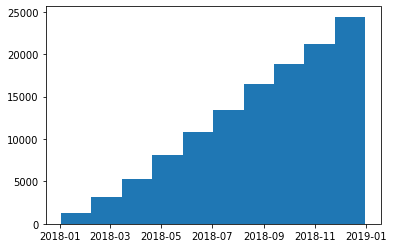

In [26]:
# сообщения
plt.hist(data=messages, x='message_date');

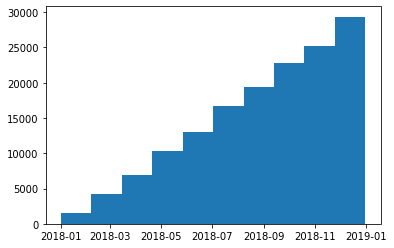

In [27]:
# интернет-трафик
plt.hist(data=internet, x='session_date');

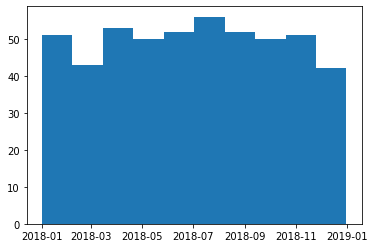

In [28]:
# пользователи, дата подключения тарифа
plt.hist(data=users, x='reg_date');

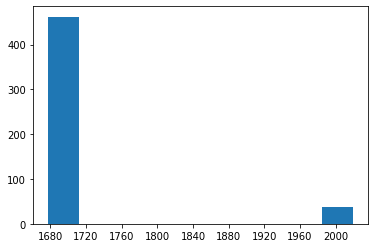

In [29]:
# пользователи, дата прекращения пользования тарифом
plt.hist(data=users, x='churn_date');

##### Числовые данные

In [30]:
# звонки
calls.describe()

,duration,user_id
count,"202,607.00","202,607.00"
mean,6.76,"1,253.94"
std,5.84,144.72
min,0.00,"1,000.00"
25%,1.30,"1,126.00"
50%,6.00,"1,260.00"
75%,10.70,"1,379.00"
max,38.00,"1,499.00"


In [31]:
# интернет
internet.describe()

,Unnamed: 0,mb_used,user_id
count,"149,396.00","149,396.00","149,396.00"
mean,"74,697.50",370.19,"1,252.10"
std,"43,127.05",278.30,144.05
min,0.00,0.00,"1,000.00"
25%,"37,348.75",138.19,"1,130.00"
50%,"74,697.50",348.01,"1,251.00"
75%,"112,046.25",559.55,"1,380.00"
max,"149,395.00","1,724.83","1,499.00"


In [32]:
# тарифы
tariffs.describe()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.00,2.00,2.00,2.00,2.00,2.00,2.00
mean,525.00,"23,040.00","1,750.00","1,250.00",175.00,2.00,2.00
std,671.75,"10,861.16","1,767.77",989.95,35.36,1.41,1.41
min,50.00,"15,360.00",500.00,550.00,150.00,1.00,1.00
25%,287.50,"19,200.00","1,125.00",900.00,162.50,1.50,1.50
50%,525.00,"23,040.00","1,750.00","1,250.00",175.00,2.00,2.00
75%,762.50,"26,880.00","2,375.00","1,600.00",187.50,2.50,2.50
max,"1,000.00","30,720.00","3,000.00","1,950.00",200.00,3.00,3.00


Видим, что минимальное значение длительности звонка `duration` равно нулю. По документации это пропущенные звонки и удалять их не нужно.

Столбец `Unnamed: 0` удалим далее.

По остальным, на первый взгляд, никаких проблем в данных нет.

##### Дубликаты

Проверим дубликаты методом `duplicated()` и просуммируем с помощью `sum()`.

In [33]:
calls.duplicated().sum()

0

In [34]:
messages.duplicated().sum()

0

In [35]:
internet.duplicated().sum()

0

In [36]:
users.duplicated().sum()

0

In [37]:
tariffs.duplicated().sum()

0

Полных дубликатов в данных нет.

##### Удаление ненужных данных

Удалим столбец методом `drop()`, где укажем имя столбца, который нужно удалить. 

Параметр `axis=1` применятеся для удаления столбца (для строк он равен 0). 

Параметр `inplace` отвечает за изменение исходного датасета. Устанавливаем его равным `True`, чтобы изменения вступили в силу.

In [38]:
internet.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,"1,052.81",2018-09-07,1000
2,1000_2,"1,197.26",2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


##### Вывод

Все данные проверены и готовы к выполнению расчётов, группировке и последующему объединению в общий датасет.

#### 3. Группировка данных

Объединим данные по `user_id` и месяцу. Таким образом мы определим для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;

Для этого нам потребуется предварительно:
1. Округлить длительность звонков в большую сторону;
2. Перевести мегабайты в гигабайты и результат округлить в большую сторону;
3. Выделить из дат звонков/сообщений/интернет-сессий месяцы.

##### Подготовка к группировке

1. Округление звонков.

Округлим длительность звонков в большую сторону. Результат добавим к данным в таблицу `calls` отдельным столбцом `ceil_call_duration`.

In [39]:
calls['ceil_call_duration'] = calls['duration'].apply(pd.np.ceil)
calls['ceil_call_duration'].head()

0    0.00
1    0.00
2    3.00
3   14.00
4    6.00
Name: ceil_call_duration, dtype: float64

2. Перевод в гигабайты и округление интернет-трафика.

Для интернет-трафика переведем мегабайты в гигабайты и также округлим в большую сторону. Результат добавим в таблицу `internet` столбцом `ceil_gb_used`.

In [40]:
internet['ceil_gb_used'] = (internet['mb_used'] / 1024).apply(pd.np.ceil)
internet['ceil_gb_used'].head()

0   1.00
1   2.00
2   2.00
3   1.00
4   1.00
Name: ceil_gb_used, dtype: float64

3. Определение месяцев

Из дат звонков/сообщений/интернет сессий выделим номер месяца с помощью атрибута `dt`. После этого применим атрибут `month` для получения номера месяца. Результат отобразим в отдельном столбце с именем `month`.

In [41]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

Проверим наличие нового столбца `month` и его тип данных для каждого датасета.

In [42]:
calls['month'].head()

0     7
1     8
2     6
3     9
4    12
Name: month, dtype: int64

In [43]:
messages['month'].head()

0     6
1    10
2     8
3     6
4    12
Name: month, dtype: int64

In [44]:
internet['month'].head()

0    11
1     9
2     6
3     8
4     9
Name: month, dtype: int64

**Вывод**

Подготовка к группировке прошла успешно. Теперь можно группировать данные.

##### Группировка

Объединяем данные по `user_id` и `month` для звонков, сообщений и интернет-трафика. Воспользуемся методом `groupby()`.

In [45]:
calls_gr = calls.groupby(['user_id', 'month']).agg({'ceil_call_duration':'sum', 'id':'count'}).reset_index()
calls_gr.head()

,user_id,month,ceil_call_duration,id
0,1000,5,159.00,22
1,1000,6,172.00,43
2,1000,7,340.00,47
3,1000,8,408.00,52
4,1000,9,466.00,58


In [46]:
internet_gr = internet.groupby(['user_id', 'month']).agg({'ceil_gb_used':'sum'}).reset_index()
internet_gr.head()

,user_id,month,ceil_gb_used
0,1000,5,4.00
1,1000,6,49.00
2,1000,7,28.00
3,1000,8,27.00
4,1000,9,26.00


In [47]:
messages_gr = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index()
messages_gr.head()

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


#### Подготовка и объединение данных в один датасет:

Изменим название столбцов `id` звонков и сообщений, а так же `tariff_name` на `tariff` для удобства объединения данных в одну таблицу:

In [48]:
calls_gr = calls_gr.rename(columns={'id':'calls_count'})
messages_gr = messages_gr.rename(columns={'id':'messages_count'})
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

Последовательно объединим данные в датасет `data`:

Для начала объединим `calls_gr`, `messages_gr` и `internet_gr` в промежуточный датасет `df_gr` по столбцам `user_id` и `month`.

In [49]:
df_gr = calls_gr.merge(messages_gr, on=['user_id', 'month'], how='outer')\
        .merge(internet_gr, on=['user_id', 'month'], how='outer')
df_gr.head()

,user_id,month,ceil_call_duration,calls_count,messages_count,ceil_gb_used
0,1000,5,159.00,22.00,22.00,4.00
1,1000,6,172.00,43.00,60.00,49.00
2,1000,7,340.00,47.00,75.00,28.00
3,1000,8,408.00,52.00,81.00,27.00
4,1000,9,466.00,58.00,57.00,26.00


Теперь объединим промежуточный датасет `df_gr` и `users` по столбцу `user_id`, а затем с `tariffs` по столбцу `tariff`.

In [50]:
data = df_gr.merge(users, on='user_id', how='outer')\
            .merge(tariffs, on='tariff', how='outer')

display(data.head())
display(data.info())

,user_id,month,ceil_call_duration,calls_count,messages_count,ceil_gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.00,159.00,22.00,22.00,4.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.00,172.00,43.00,60.00,49.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.00,340.00,47.00,75.00,28.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.00,408.00,52.00,81.00,27.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.00,466.00,58.00,57.00,26.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 20 columns):
user_id                  3216 non-null int64
month                    3214 non-null float64
ceil_call_duration       3174 non-null float64
calls_count              3174 non-null float64
messages_count           2717 non-null float64
ceil_gb_used             3203 non-null float64
age                      3216 non-null int64
churn_date               189 non-null datetime64[ns]
city                     3216 non-null object
first_name               3216 non-null object
last_name                3216 non-null object
reg_date                 3216 non-null datetime64[ns]
tariff                   3216 non-null object
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per

None

После объединения видим, что появились пропуски в данных. Заполним пропуски в услугах нулями - так мы обозначим, что пользователь в данном месяце не пользовался какой-то из услуг.

Для расчета помесячной выручки нас интересуют столбцы: `calls_count`, `ceil_call_duration`, `messages_count`, `ceil_gb_used`.

In [51]:
data['calls_count'] = data['calls_count'].fillna(0)
data['ceil_call_duration'] = data['ceil_call_duration'].fillna(0)
data['messages_count'] = data['messages_count'].fillna(0)
data['ceil_gb_used'] = data['ceil_gb_used'].fillna(0)

В столбце `month` есть 2 пропуска. Посмотрим на них подробнее.

In [52]:
data[data['month'].isna()]

,user_id,month,ceil_call_duration,calls_count,messages_count,ceil_gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
985,1128,nan,0.00,0.00,0.00,0.00,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1
3215,1371,nan,0.00,0.00,0.00,0.00,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,50,15360,500,550,200,3,3


Видим, что пользователи вообще не пользовались ни одной из услуг, поэтому выручка будет равна нулю и можно удалить эти строки.

In [53]:
data.dropna(subset=['month'], inplace=True)

# проверка
data['month'].isna().sum()

0

#### Определение помесячной выручки:

Добавим в получившийся датасет столбец `proceed_per_month`, в котором отразим помесячную выручку с каждого пользователя. Для этого:
1. вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;
2. остаток умножим на значение из тарифного плана;
3. прибавим абонентскую плату, соответствующую тарифному плану.

In [54]:
def calculate_proceed_per_month(row):
    # Информация по звонкам, сообщениям, мегабайтам за месяц
    calls_count = row['calls_count']
    calls_duration = row['ceil_call_duration']
    messages_count = row['messages_count']
    ceil_gb_used = row['ceil_gb_used']
    
    # Включено в тариф
    messages_included = row['messages_included']
    mb_included = row['mb_per_month_included']
    minutes_included = row['minutes_included']
    
    # Стоимость по тарифу за минуту, гигабайт, сообщение
    rub_per_minute = row['rub_per_minute']
    rub_per_message = row['rub_per_message']
    rub_per_gb = row['rub_per_gb']
    
    # Абонентская плата
    rub_monthly_fee = row['rub_monthly_fee']
    
    # Рассчёт переплаты за звонки
    calls_overpay = (calls_duration - minutes_included) * rub_per_minute
    # Если переплата меньше нуля, то приравняем к нулю, то есть переплаты нет.
    if calls_overpay <= 0:
        calls_overpay = 0
    # (аналогично по сообщениям и трафику)
    messages_overpay = (messages_count - messages_included) * rub_per_message
    if messages_overpay <= 0:
        messages_overpay = 0
    
    gb_used_overpay = (ceil_gb_used - mb_included / 1024) * rub_per_gb
    if gb_used_overpay <= 0:
        gb_used_overpay = 0
    
    # Суммарная плата за месяц из абонентской и всех переплат
    proceed_per_month = calls_overpay + messages_overpay + gb_used_overpay + rub_monthly_fee
        
    return proceed_per_month

In [55]:
data['proceed_per_month'] = data.apply(calculate_proceed_per_month, axis=1)

In [56]:
data['proceed_per_month'].head()

0   1,950.00
1   4,800.00
2   1,950.00
3   1,950.00
4   1,950.00
Name: proceed_per_month, dtype: float64

### Вывод

По итогу, мы подготовили данные к дальнейшему анализу, произведя следующие действия:
1. Открыли все необходимые для исследования датасеты;
2. Выполнили предобработку;
3. Сгруппировали данные по нужным метрикам и добавили новые столбцы;
4. Объединили в один датасет;
5. Добавили столбец помесячной выручки;

## Анализ данных выборки

### Подготовка к анализу

Разделим датасет на 2 части по тарифам:

In [57]:
data_smart = data[data['tariff'] == 'smart']
data_ultra = data[data['tariff'] == 'ultra']

In [58]:
data_smart.head()

,user_id,month,ceil_call_duration,calls_count,messages_count,ceil_gb_used,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,proceed_per_month
986,1001,11.00,430.00,59.00,0.00,47.00,41,NaT,Москва,Иван,...,2018-11-01,smart,50,15360,500,550,200,3,3,"6,950.00"
987,1001,12.00,414.00,63.00,0.00,35.00,41,NaT,Москва,Иван,...,2018-11-01,smart,50,15360,500,550,200,3,3,"4,550.00"
988,1002,6.00,117.00,15.00,4.00,27.00,59,NaT,Стерлитамак,Евгений,...,2018-06-17,smart,50,15360,500,550,200,3,3,"2,950.00"
989,1002,7.00,214.00,26.00,11.00,45.00,59,NaT,Стерлитамак,Евгений,...,2018-06-17,smart,50,15360,500,550,200,3,3,"6,550.00"
990,1002,8.00,289.00,42.00,13.00,50.00,59,NaT,Стерлитамак,Евгений,...,2018-06-17,smart,50,15360,500,550,200,3,3,"7,550.00"


In [59]:
data_ultra.head()

,user_id,month,ceil_call_duration,calls_count,messages_count,ceil_gb_used,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,proceed_per_month
0,1000,5.00,159.00,22.00,22.00,4.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"
1,1000,6.00,172.00,43.00,60.00,49.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"4,800.00"
2,1000,7.00,340.00,47.00,75.00,28.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"
3,1000,8.00,408.00,52.00,81.00,27.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"
4,1000,9.00,466.00,58.00,57.00,26.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"


Определим, сколько минут разговора, сообщений и объём интернет трафика требуется пользователям каждого тарифа в месяц.
Начнем с тарифа `smart`.

### Тариф `Smart`

Построим гистограммы для длительности звонков, количества сообщений и интернет-трафика:

#### Продолжительность звонков

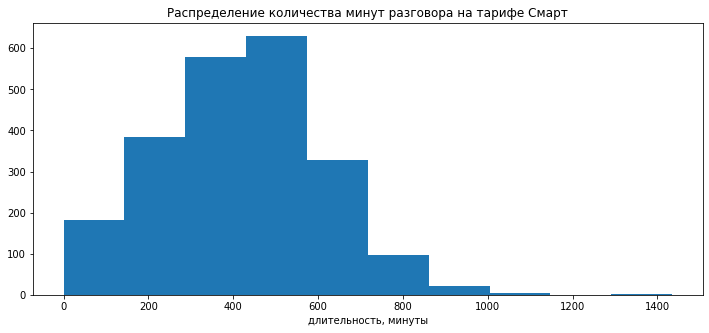

In [60]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.set_title('Распределение количества минут разговора на тарифе Смарт')
ax.set_xlabel('длительность, минуты');

ax.hist(data=data_smart, x='ceil_call_duration');

#### Количество сообщений

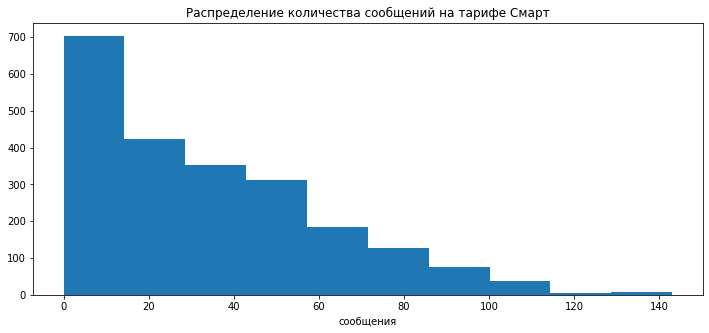

In [61]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.set_title('Распределение количества сообщений на тарифе Смарт')
ax.set_xlabel('сообщения');

ax.hist(data=data_smart, x='messages_count');

#### Интернет-трафик

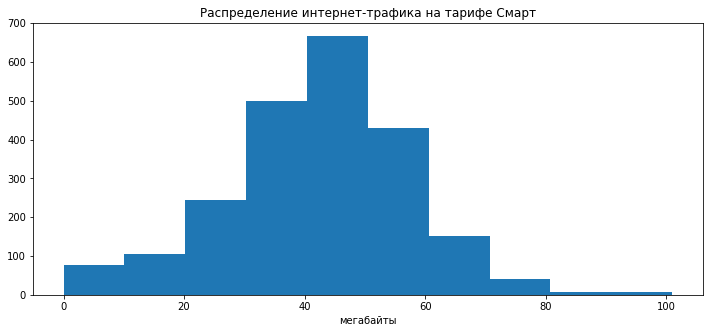

In [62]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.set_title('Распределение интернет-трафика на тарифе Смарт')
ax.set_xlabel('мегабайты');

ax.hist(data=data_smart, x='ceil_gb_used');

### Тариф `Ultra`

#### Продолжительность звонков

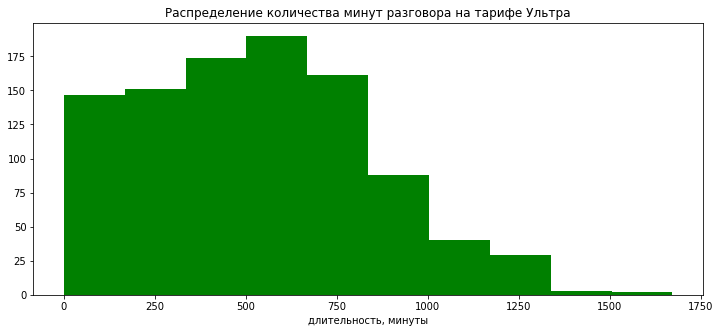

In [63]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.set_title('Распределение количества минут разговора на тарифе Ультра')
ax.set_xlabel('длительность, минуты');

ax.hist(data=data_ultra, x='ceil_call_duration', color='green');

#### Количество сообщений

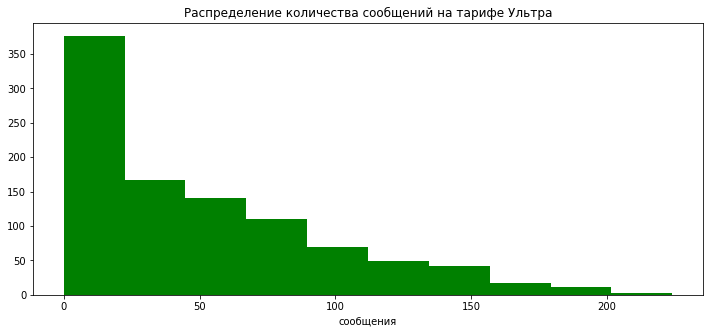

In [64]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.set_title('Распределение количества сообщений на тарифе Ультра')
ax.set_xlabel('сообщения');

ax.hist(data=data_ultra, x='messages_count', color='green');

#### Интернет-трафик

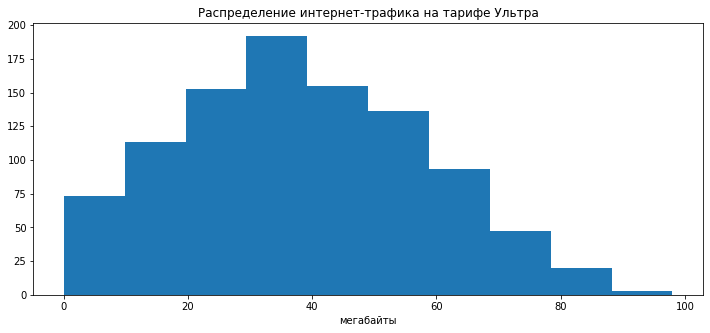

In [65]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.set_title('Распределение интернет-трафика на тарифе Ультра')
ax.set_xlabel('мегабайты');

ax.hist(data=data_ultra, x='ceil_gb_used');

### Вывод

Методы построения графиков являются наглядной, но качественной оценкой нормальности распределения. На гистограммах звонков и интернет-трафика мы видим, что распределение не похоже на привычный "колокол" гауссовского распределения. Гистограмма сообщений похожа лишь на нисходящую часть "колокола".

Для уточнения нормальности можно провести ряд статических тестов, но они также не могут однозначно определить - нормальное распределение или нет.

Если одни методы показывают, что распределение похоже на гауссовское, а другие нет, то можно принять тот факт, что данные подобны нормальному распределению.

Во многих ситуациях можно обрабатывать данные, как если бы они были гауссовскими. Поэтому и опираясь на гистограммы, будем считать распределения нормальными.

## Проверка гипотез

Необходимо проверить 2 гипотезы:
1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

#### Получение выборок из данных

Будем сравнивать средние значения выручки разных тарифов. Поэтому необходимо разделить данные на 2 части по тарифу.

In [66]:
data_smart = data[data['tariff'] == 'smart']
data_smart.head()

,user_id,month,ceil_call_duration,calls_count,messages_count,ceil_gb_used,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,proceed_per_month
986,1001,11.00,430.00,59.00,0.00,47.00,41,NaT,Москва,Иван,...,2018-11-01,smart,50,15360,500,550,200,3,3,"6,950.00"
987,1001,12.00,414.00,63.00,0.00,35.00,41,NaT,Москва,Иван,...,2018-11-01,smart,50,15360,500,550,200,3,3,"4,550.00"
988,1002,6.00,117.00,15.00,4.00,27.00,59,NaT,Стерлитамак,Евгений,...,2018-06-17,smart,50,15360,500,550,200,3,3,"2,950.00"
989,1002,7.00,214.00,26.00,11.00,45.00,59,NaT,Стерлитамак,Евгений,...,2018-06-17,smart,50,15360,500,550,200,3,3,"6,550.00"
990,1002,8.00,289.00,42.00,13.00,50.00,59,NaT,Стерлитамак,Евгений,...,2018-06-17,smart,50,15360,500,550,200,3,3,"7,550.00"


In [67]:
data_ultra = data[data['tariff'] == 'ultra']
data_ultra.head()

,user_id,month,ceil_call_duration,calls_count,messages_count,ceil_gb_used,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,proceed_per_month
0,1000,5.00,159.00,22.00,22.00,4.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"
1,1000,6.00,172.00,43.00,60.00,49.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"4,800.00"
2,1000,7.00,340.00,47.00,75.00,28.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"
3,1000,8.00,408.00,52.00,81.00,27.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"
4,1000,9.00,466.00,58.00,57.00,26.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"


Выборки готовы. Перейдем к формированию гипотез.

#### Нулевая и альтернативная гипотезы

Для проверки основной гипотезы о неравенстве средних выручки от пользователей разных тарифов сформируем нулевую и альтернативную гипотезы:

- `H0`(нулевая гипотеза) - средняя выручка пользователей тарифов «Ультра» и «Смарт» равны;
- `H1`(альтернативная гипотеза) - средняя выручка пользователей тарифов «Ультра» и «Смарт» НЕ равны.

Так же для проверки нам понадобится определить пороговое значение <b>уровеня значимости</b>. Обозначим его `alpha` и примем равным `5%`.

In [68]:
alpha = 0.05

#### Расчет и проверка условия

В библиотеке `scipy` есть специальный метод, позволяющий оценить уровень значимости - `st.ttest_ind(arr_1, arr_2, equal_var=True)`, где `arr_1` и `arr_2` - выборки, а `equal_var`, равный по умолчанию `True`, это необязательный параметр, задающий считать ли равными дисперсии двух выборок.

Проверим равенство дисперсий тестом Бартлетта.

In [69]:
st.bartlett(data_smart['proceed_per_month'], data_ultra['proceed_per_month'])

BartlettResult(statistic=105.22344445305663, pvalue=1.0911125602537496e-24)

Очень маленькое значение рvalue предполагает, что выборки не имеют одинаковой дисперсии. Дисперсии отличаются более чем на 5%, значит принимаем `equal_var=False`.

In [70]:
results = st.ttest_ind(
    data_smart['proceed_per_month'],
    data_ultra['proceed_per_month'], equal_var=False)

In [71]:
print('p-value:', results.pvalue)

p-value: 3.366123216919074e-132


Запишем условие, по которому отвергается или не отвергается нулевая гипотеза:

In [72]:
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


In [73]:
data_smart['proceed_per_month'].describe()

count    2,229.00
mean     6,247.08
std      2,893.72
min        550.00
25%      4,503.00
50%      6,350.00
75%      8,065.00
max     19,370.00
Name: proceed_per_month, dtype: float64

In [74]:
data_ultra['proceed_per_month'].describe()

count      985.00
mean     3,844.42
std      2,166.14
min      1,950.00
25%      1,950.00
50%      3,150.00
75%      5,250.00
max     12,150.00
Name: proceed_per_month, dtype: float64

#### Вывод

В результате мы отвергли нулевую гипотезу, по которой средние выручки пользователей двух разных тарифов равны (не различаются).
Значит мы принимаем альтернативную гипотезу, по которой они различаются. Это значит, что есть основание полагать, что изначальная гипотеза "средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются" верна. Средняя выручка от пользователей с тарифом `smart` выше.

### средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

#### Получение выборок из данных

In [75]:
data_moscow = data[data['city'] == 'Москва']
data_moscow.head()

,user_id,month,ceil_call_duration,calls_count,messages_count,ceil_gb_used,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,proceed_per_month
8,1003,8.00,380.00,55.00,37.00,14.00,23,NaT,Москва,Белла,...,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"
9,1003,9.00,961.00,134.00,91.00,23.00,23,NaT,Москва,Белла,...,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"
10,1003,10.00,855.00,108.00,83.00,28.00,23,NaT,Москва,Белла,...,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"
11,1003,11.00,824.00,115.00,94.00,20.00,23,NaT,Москва,Белла,...,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"
12,1003,12.00,802.00,108.00,75.00,21.00,23,NaT,Москва,Белла,...,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"


In [76]:
data_wo_moscow = data[data['city'] != 'Москва']
data_wo_moscow.head()

,user_id,month,ceil_call_duration,calls_count,messages_count,ceil_gb_used,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,proceed_per_month
0,1000,5.00,159.00,22.00,22.00,4.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"
1,1000,6.00,172.00,43.00,60.00,49.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"4,800.00"
2,1000,7.00,340.00,47.00,75.00,28.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"
3,1000,8.00,408.00,52.00,81.00,27.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"
4,1000,9.00,466.00,58.00,57.00,26.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,"1,950.00"


#### Нулевая и альтернативная гипотезы

- `H0`(нулевая гипотеза) - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов;
- `H1`(альтернативная гипотеза) - средняя выручка пользователей из Москвы НЕ равна выручке пользователей из других регионов.

<b>Уровень значимости</b> `alpha_1`. Примем равным `5%`.

In [77]:
alpha_1 = 0.05

#### Расчет и проверка условия

In [78]:
st.bartlett(data_moscow['proceed_per_month'], data_wo_moscow['proceed_per_month'])

BartlettResult(statistic=9.205413937109192, pvalue=0.0024130042809939536)

Принимаем `equal_var=False`.

In [79]:
results_msk = st.ttest_ind(
    data_moscow['proceed_per_month'],
    data_wo_moscow['proceed_per_month'], equal_var=False)

In [80]:
print('p-value:', results_msk.pvalue)

p-value: 0.25438147756433427


In [81]:
if (results_msk.pvalue < alpha_1):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Не получилось отвергнуть нулевую гипотезу


In [82]:
data_moscow['proceed_per_month'].describe()

count      611.00
mean     5,397.04
std      2,683.24
min        550.00
25%      3,300.00
50%      5,350.00
75%      7,185.50
max     17,121.00
Name: proceed_per_month, dtype: float64

In [83]:
data_wo_moscow['proceed_per_month'].describe()

count    2,603.00
mean     5,537.42
std      2,961.15
min        550.00
25%      2,950.00
50%      5,550.00
75%      7,558.50
max     19,370.00
Name: proceed_per_month, dtype: float64

#### Вывод

В результате не получилось отвергнуть нулевую гипотезу, по которой средние выручки пользователей из Москвы и остальных регионов равны (не различаются). Значит есть основание предполагать, что эта гипотеза верна.

## Вывод

В результате анализа данных мы увидели, что распределение звонков и интернет трафика приближенно к нормальному. Сообщения имеют вид нисходящего распределения. Это можно объяснить тем, что сообщениями со временем клиенты пользуются все реже. Чаще всего люди либо звонят, либо общаются в социальных сетях и мессенджерах через интернет.

Проверка гипотез дала нам основания предполагать, что:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. Сравнив средние значения выручки статических характеристик выборок данных с разными тарифами оказалось, что средняя выручка с услуг клиентов с тарифом `smart` больше. Это можно объяснить тем, что пользователи при выборе тарифа чаще всего останавливаются на том, который дешевле и включается в себя достаточное количество минут для разговоров, минимум сообщений и объём интернет-трафика, достаточного для пользования социальными сетями и компенсированием общения сообщениями через мессенджеры;
- средние выручки пользователей из Москвы и остальных регионов равны. По средним значениям статических характеристик видно, что они примерно одинаковые на момент выгрузки данных.

Таким образом, по результатам исследования можно сделать вывод о том, что тариф "Смарт" наиболее привлекателен для пользователей разных городов (миллионников, средних и малых) и, соответственно, оказался наиболее прибыльнее.